In [3]:
#libraries
import numpy as np
from scipy.integrate import solve_ivp
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt

In [4]:
#general constants
g = 9.81
rocketDragCoef = 0.4
crossSectArea= 0.028
mInitial = 20
airBrakeCoeff = 2
airBrakeCrossSect = 0.015
rho_0 =  1.225
e = 2.718281828459045


In [13]:
#air density data
rawAirDensity = np.loadtxt(r"rocketData\air_density.csv", delimiter=',')  # Adjust skiprows based on your file's structure
airDensePoints = rawAirDensity.transpose()
#airDenseFunc = interpolate.CubicSpline(airDensePoints[0], airDensePoints[1])
a = 1.00367
b = -0.000101227
c = -0.000293537


def airDenseFunc(h):
    return a * e**(b*h)

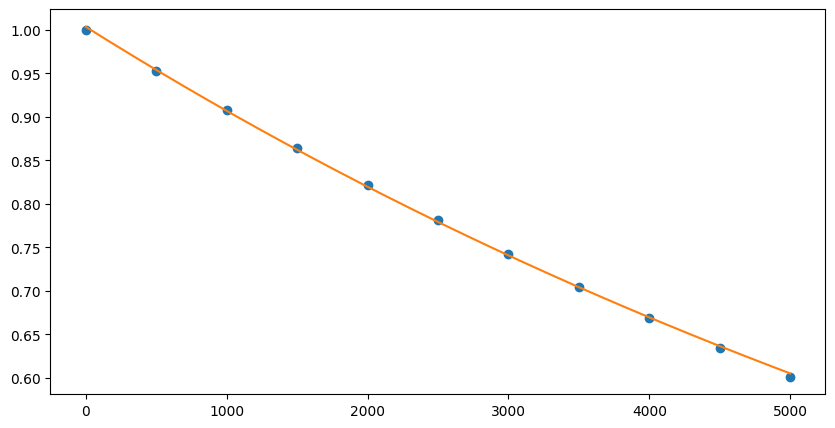

In [14]:
height =  np.linspace(0, 5000,5000)
sampleAirDensity = airDenseFunc(height)

plt.figure(figsize=(10,5))
plt.plot(airDensePoints[0], airDensePoints[1], 'o', label='Data Points')
plt.plot(height,sampleAirDensity)
plt.show()

In [15]:
#thrust data 
rawThrust = np.loadtxt(r'rocketData\thrust_curve.csv', delimiter=',')  # Adjust skiprows based on your file's structure
thrustPoints = rawThrust.transpose()
thrustFunc = interpolate.Akima1DInterpolator(thrustPoints[0], thrustPoints[1])

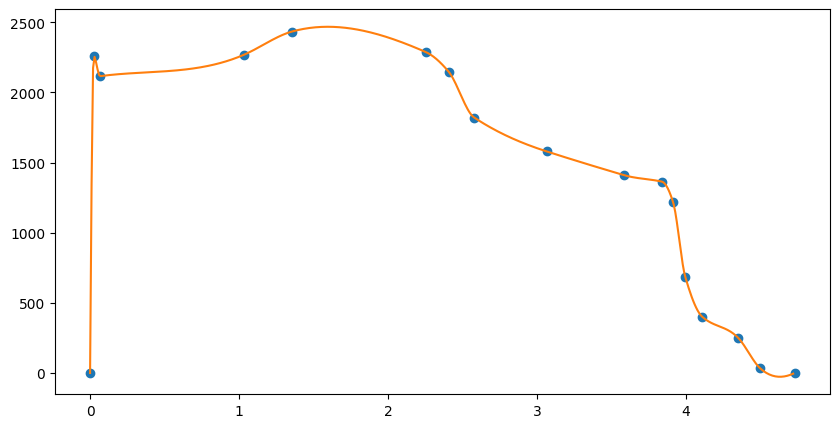

In [16]:
time =  np.linspace(0, 5, 500)
sampleThrust = thrustFunc(time)

plt.figure(figsize=(10,5))
plt.plot(thrustPoints[0], thrustPoints[1], 'o', label='Data Points')
plt.plot(time,sampleThrust)
plt.show()

In [17]:
#thrust curve 
def thrust(t):
    if t >= 0 and t <= 4.729:
        return thrustFunc(t)
    else:
        return 0 

In [19]:
#air density as a function of altitude 
def air_density(h):
    if (h >= 0 and h <= 5000):
        return rho_0 * airDenseFunc(h)
    
    elif():
        return

    else:
        return 0

In [20]:
def mass(t):
    burnRate = 3.717/4.5
    if t >= 0 and t <= 4.5:
        return mInitial - burnRate * t
    else:
        return mInitial - 3.717

In [21]:
#rocket drag given by velocity and height
def rocket_drag(v,h):
    rho = air_density(h)
    return 0.5 * rho * v**2 * rocketDragCoef * crossSectArea

In [22]:
def air_brake_drag(v,h,theta):
    rho = air_density(h)
    if 0 <= theta <= 1:
        return 0.5 * rho * v**2 * airBrakeCoeff * (airBrakeCrossSect * theta)
    else:
        return 0

In [23]:
def dynamic_equations(t,y,theta):
    h, v = y
    m = mass(t)
    T = thrust(t)
    D = rocket_drag(v, h)
    Dab= air_brake_drag(v,h,theta)
    dvdt = (T-D-Dab-m*g)/m
    dhdt = v

    return [dhdt, dvdt]


In [24]:
#simulation parameters
desired_apogee = 3000
Kp = 0.00003
Ki = 0.000002
Kd = 0.00000005

In [25]:
# PID control function
def pid_controller(setpoint, actual, prevError, integral, dt):
    error = setpoint - actual
    integral = error * dt
    derivative = (error - prevError)/dt
    output =  Kp * error + Ki * integral + Kd * derivative
    return output, error, integral

In [110]:
# Initial conditions
y0 = [0, 0]  # initial altitude and velocity
t_span = (0, 120)  # time span for the simulation

integral = 0
prevError = 0
deployment = 0

# Time points for output
tPoints = np.linspace(t_span[0], t_span[1], 1200) 

#the objective is to have 3 arrays with altitude with respect to time, velocity with respect to time and air brake deployment with respect to time
# run the simulation with the PID control system
altitude = []
velocity = []
deploymentVals = [] 
for i in range(0,len(tPoints)):
    currentTime = tPoints[i]
    if i == 0:
        currentState = y0
        dt = tPoints[1]-tPoints[0]
    else:
        dt = tPoints[i] - tPoints[i-1]
        
    
    deployment, prevError, integral = pid_controller(desired_apogee,currentState[0], prevError, integral, dt)
    deployment = max(0,min(deployment, 1))

    print(f"Time: {currentTime}, Deployment Length: {deployment}, Altitude: {currentState[0]}, Velocity: {currentState[1]}")
    

    solution = solve_ivp(dynamic_equations, [currentTime, currentTime + dt], currentState, args= (deployment,), t_eval= [currentTime + dt])

    currentState = np.array(solution.y[:,-1])

    # Set velocity to zero if altitude is zero or below
    if currentState[0] <= 0:
        currentState[0] = 0
        currentState[1] = 0

    # Store the results
    altitude.append(currentState[0])
    velocity.append(currentState[1])
    deploymentVals.append(deployment)


Time: 0.0, Deployment Length: 0.09209925041701417, Altitude: 0, Velocity: 0
Time: 0.10008340283569642, Deployment Length: 0.09058786213389873, Altitude: 0.41167381031522676, Velocity: 8.945237156883678
Time: 0.20016680567139283, Deployment Length: 0.0905456802036113, Altitude: 1.7923884894217177, Velocity: 18.660325686239872
Time: 0.3002502085070893, Deployment Length: 0.09047401396344412, Altitude: 4.149281359276623, Velocity: 28.448542325520325
Time: 0.40033361134278567, Deployment Length: 0.09037267446294708, Altitude: 7.488623354865798, Velocity: 38.29044578098146
Time: 0.5004170141784821, Deployment Length: 0.0902415181137134, Altitude: 11.815193709268646, Velocity: 48.175699269357054
Time: 0.6005004170141786, Deployment Length: 0.09008041813171098, Altitude: 17.133200002568774, Velocity: 58.103241208313456
Time: 0.700583819849875, Deployment Length: 0.0898892362828669, Altitude: 23.44721348076024, Velocity: 68.08141933441044
Time: 0.8006672226855713, Deployment Length: 0.08966779

In [105]:
maxHeight = max(altitude)
maxVel = max(velocity)

print(maxHeight)
print(maxVel)

2787.8960674423815
311.45469677942225


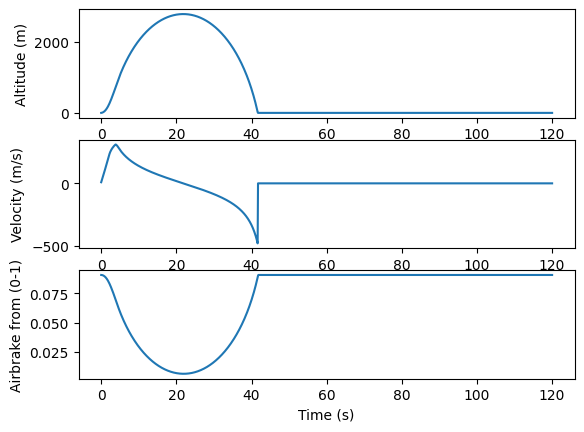

In [109]:
# Plotting results
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(tPoints, altitude)
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.subplot(3, 1, 2)
plt.plot(tPoints, velocity)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.subplot(3, 1, 3)
plt.plot(tPoints, deploymentVals)
plt.xlabel('Time (s)')
plt.ylabel('Airbrake from (0-1)')
plt.show()
